In [13]:
# Step 1: Import libraries
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
import pandas as pd
from sklearn.model_selection import train_test_split
from scipy.constants import c as speed_of_light
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
import pickle
from mpl_toolkits.mplot3d import Axes3D

In [3]:
def total_flux(wl, flux_nu):
    """
    Calculate the total flux over the wavelengths and returns the flux in erg cm^-2 s^-1
    """
    flux_lambda = (speed_of_light * 100 / ((wl * 1e-4) ** 2)) * flux_nu * 1e-23
    tot_flux = np.trapezoid(flux_lambda, (wl * 1e-4))
    return tot_flux

In [6]:
with open('FLiTsData1000.pkl', 'rb') as f:
    df = pickle.load(f)

In [8]:
data = []
species = ['atomic', 'C2H2', 'CH4', 'CO', 'CO2', 'H2O', 'HCN', 'NH3', 'NO', 'O2', 'OH']
for i, row in df.iterrows():
    fluxes = []
    for specie in species:
        fluxes.append(total_flux(row[f'FLiTs {specie} Wavelength'], row[f'FLiTs {specie} Flux']))
    data.append(fluxes)
df_FLiTs_flux = pd.DataFrame(data, columns=species)
print(df_FLiTs_flux)

          atomic          C2H2           CH4            CO           CO2  \
0   7.479708e-15 -1.404080e-14  4.877943e-17  5.771112e-13  1.166385e-14   
1   1.192786e-14 -2.750180e-14  4.049405e-17  6.584515e-13  2.472750e-14   
2   1.229322e-14 -3.944518e-14  2.850269e-17  7.159074e-13  4.030173e-14   
3   1.401599e-14 -5.075966e-14  1.577024e-17  7.884372e-13  6.193433e-14   
4   7.854032e-15 -5.935766e-14  6.071154e-18  8.497314e-13  9.515077e-14   
5   1.161335e-14 -6.326414e-15  7.151217e-17  5.826977e-13  8.175568e-15   
6   7.737988e-15 -1.966487e-14  5.668986e-17  6.844452e-13  3.016163e-14   
7   1.192691e-14 -3.226233e-14  4.225535e-17  7.376856e-13  6.262205e-14   
8   1.356214e-14 -4.277096e-14  2.277206e-17  7.986946e-13  1.027196e-13   
9   1.165193e-14 -5.848076e-14  8.502495e-18  8.689227e-13  1.593780e-13   
10  1.037775e-14  3.875595e-12  2.502220e-16  8.807906e-13  1.897842e-17   
11  1.173054e-14 -1.011061e-14  1.692626e-16  5.648054e-13  1.934740e-14   
12  7.881810

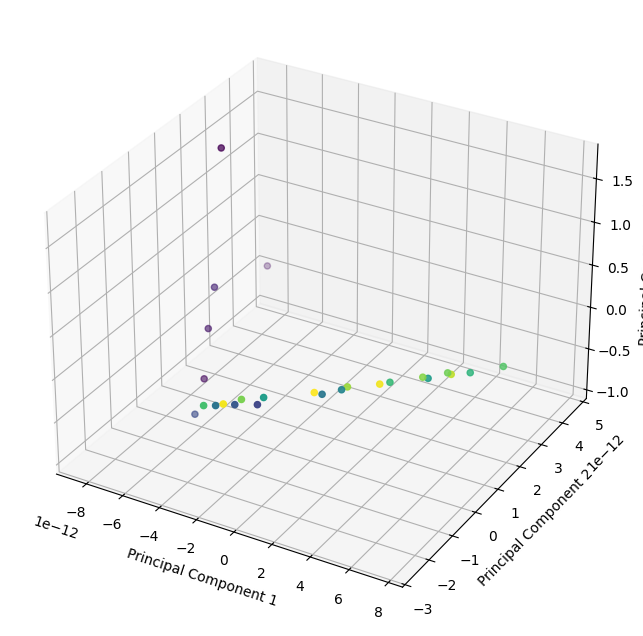

In [37]:
target_column = 'NH3'
X = df_FLiTs_flux.drop(columns=[target_column])
y = df_FLiTs_flux[target_column]
pca = PCA(n_components=3)
X_pca = pca.fit_transform(X)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2], c=y, cmap='viridis')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_zlabel('Principal Component 3')
plt.show()

In [136]:
from sklearn.svm import SVR
X_train, X_test, Y_train, Y_test = train_test_split(X_pca, y, test_size=0.2)

# Step 3: Initialize the RandomForestClassifier
rf = RandomForestRegressor(n_estimators=100)
svm_regressor = SVR(kernel='rbf', C=100, epsilon=0.1)

svm_regressor.fit(X_train, Y_train)

Y_pred_regressor = svm_regressor.predict(X_test)

mse = mean_squared_error(Y_test, Y_pred_regressor)
r2 = r2_score(Y_test, Y_pred_regressor)
print(f'RMSE: {np.sqrt(mse)}')
print(f'R-squared: {r2}')

RMSE: 1.459833322927134e-15
R-squared: -0.04280757018877224


In [102]:
from sklearn.model_selection import GridSearchCV

# Define the model
rf = RandomForestRegressor(random_state=42)

# Hyperparameter grid for tuning
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
}

# Use GridSearchCV to find the best parameters
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Best model
best_rf = grid_search.best_estimator_

# Predict and evaluate the model
y_pred = best_rf.predict(X_test)
r2 = r2_score(Y_test, y_pred)
print(f'Optimized R-squared: {r2}')

Optimized R-squared: -0.004175050119119117


In [137]:
param_grid = {
    'C': [0.1, 1, 10, 100],
    'epsilon': [0.01, 0.1, 0.2],
    'kernel': ['linear', 'rbf', 'poly']
}

# Perform grid search with cross-validation
grid_search = GridSearchCV(SVR(), param_grid, cv=5)
grid_search.fit(X_train, Y_train)

# Get the best parameters
best_svr = grid_search.best_estimator_

# Predict and evaluate the optimized model
Y_pred_best = best_svr.predict(X_test)
print(f'Optimized R-squared: {r2_score(Y_test, Y_pred_best)}')

Optimized R-squared: -0.04280757018877224
